In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from subprocess import Popen, PIPE, STDOUT
import matplotlib.pyplot as plt
import os
from copy import deepcopy
import galsim 

In [4]:
#directories that would be using 
repo = '/Users/Ismael/code/lensing/SMFF/'
os.chdir(repo)

In [5]:
#colormap default to use for galaxy 
cmap = 'RdYlGn'

In [6]:
def showImage(image,ax=None):
    if ax is None: 
        plt.imshow(image, cmap=cmap,vmax=abs(image).max(),vmin=-abs(image).max(),interpolation='None')
    else: 
        ax.imshow(image, cmap=cmap,vmax=abs(image).max(),vmin=-abs(image).max(),interpolation='None')

## Analysis of a single galaxy

### Generating a galaxy file

In [70]:
#parameters of galaxy to draw. 
model = 'gaussian' #possible options of model and psf_model are in documentation. 
psf_model = 'psf_gaussian'
g1 = .2 
g2 = 0.2 
hlr = .5 
psf_fwhm = .7
snr = 20. 

#project folder name where you want to write galaxy information 
project1 = 'project-shear'

#image parameters 
pixel_scale=.2 
nx = 40
ny = 40 


In [71]:
cmd = 'python generate.py -p {0} -gal 1 --galaxy-model {1} --psf_model {2}  --g1 {3} --g2 {4} --y0 0 --x0 0 \
--flux 1. --psf_flux 1. --hlr {5} --psf_fwhm {6} --snr {7}'.format(project1,model,psf_model,g1,g2,hlr,psf_fwhm,snr)
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output = p.stdout.read()
print output

In [85]:
cmd

'python generate.py -p project-shear -gal 1 --galaxy-model gaussian --psf_model psf_gaussian  --g1 0.2 --g2 0.2 --y0 0 --x0 0 --flux 1. --psf_flux 1. --hlr 0.5 --psf_fwhm 0.7 --snr 20.0'

### Get fisher formalism analysis from the file

In [72]:
import fisher 
import galfun 

In [73]:
g_parameters = galfun.GParameters(project1) #extract parameters from file created by generate.py 
image_renderer = galfun.ImageRenderer(pixel_scale=pixel_scale, nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer,snr=snr)

### Draw the galaxy generated 

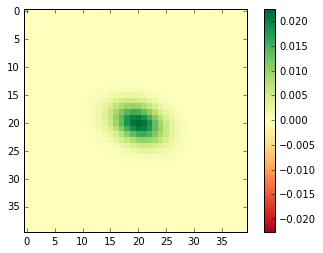

In [74]:
#get galaxy image and display it from fisher object. green is positive and red is negative 
showImage(fish.image.array)
plt.colorbar()

### Shear functions. 

In [83]:
import os
os.chdir("/Users/Ismael/code/lensing/SMFF/")

import fisher
import galfun
from copy import deepcopy
import numpy as np


def shearEllipticity(g, shear):
    """
    Changes given ellipticity to a sheared ellpticity according to the
    formula (14) of paper: http://arxiv.org/abs/1409.6273.
    Ellipticity should be given by inputting the two components.
    Returns both sheared components of ellpicity.
    Uses complex numbers.
    """
    g_s = (g + shear)/(1 + shear.conjugate()*g)
    return g_s

def shearBias(fish, image_renderer, shear):
    """Returns the value of the bias of the given lensing shear for the
    particular galaxy analyzed by using the ring test. Only works with
    a single galaxy profile.
    Assume galaxy is parametrized with g1,g2.
    """
    angle_range = (0, 2*np.pi)
    steps = 7 #6 points on the ring. excluding theta=2pi
    id_params = deepcopy(fish.g_parameters.id_params)
    ids = id_params.keys()
    id1 = ids[0]
    snr = fish.snr
    angles = list(np.linspace(angle_range[0], angle_range[1], steps))
    angles.pop() #remove 2pi angle redundancy.
    biases = []
    orig_g1 = id_params[id1]['g1']
    orig_g2 = id_params[id1]['g2']
    orig_g = complex(orig_g1,orig_g2) #unsheared ellipticity
    for angle in angles:
        g = complex(abs(orig_g)*math.cos(angle),abs(orig_g)*math.sin(angle))
        g_s = shearEllipticity(g, shear) #get sheared components
        id_params[id1]['g1'] = g_s.real
        id_params[id1]['g2'] = g_s.imag
        g_parameters = galfun.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters,image_renderer, snr)
        bias = complex(fish.biases['g1_'+id1],fish.biases['g2_'+id1])
        biases.append(bias)

    #return bias(shear) which is average of ellipticity bias
    return np.mean(biases)

def biasesEllipticities(fish,image_renderer, shear):
    """Returns a lists of the biases of both ellipticies that are in the process of being sheared.
    """
    angle_range = (0, 2*np.pi)
    steps = 7 #6 points on the ring. excluding theta=2pi
    id_params = deepcopy(fish.g_parameters.id_params)
    ids = id_params.keys()
    id1 = ids[0]
    snr = fish.snr
    angles = list(np.linspace(angle_range[0], angle_range[1], steps))
    angles.pop() #remove 2pi angle redundancy.
    biases_g1 = []
    biases_g2 = []
    orig_g1 = id_params[id1]['g1']
    orig_g2 = id_params[id1]['g2']
    orig_g = complex(orig_g1,orig_g2) #unsheared ellipticity
    for angle in angles:
        g = complex(abs(orig_e)*np.cos(angle),abs(orig_e)*np.sin(angle))
        g_s = shearEllipticity(g, shear) #get sheared components
        id_params[id1]['g1'] = g_s.real
        id_params[id1]['g2'] = g_s.imag
        g_parameters = galfun.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters,image_renderer, snr)
        biases_g1.append(fish.biases['g1_'+id1])
        biases_g2.append(fish.biases['g2_'+id1])

    #return bias(g) which is average of ellipticity bias
    return biases_e1, biases_e2

#get multiplicative and additive biases of shear by doing a linear fit.
#we let g2 be a constant  = 0
def getMultAddBiasG1(fish, image_renderer):
    shear_range = (.0001, .02)
    steps = 10 #number of points to plot.
    shear_ranges = list(np.linspace(shear_range[0], shear_range[1], steps))
    shears = []
    bs = []
    shear_2 = 0.
    for shear_1 in shear_ranges:
        shear = complex(shear_1,shear_2)
        b = shearBias(fish,image_renderer, shear)
        shears.append(shear)
        bs.append(b)
    shears_real = np.array([shear_i.real for shear_i in shears])
    shears_imag = np.array([shear_i.imag for shear_i in shears])
    bs_real = np.array([b_i.real for b_i in bs])
    bs_imag = np.array([b_i.imag for b_i in bs])
    m1, c1 = np.polyfit(shears_real, bs_real,1)
#     m2, c2 = np.polyfit(shears_imag, bs_imag, 1)
    return (m1, c1)

#get multiplicative and additive biases of shear by doing a linear fit.
#we let g1 be a constant  = 0
def getMultAddBiasG2(fish,image_renderer):
    shear_range = (.0001, .02)
    steps = 10 #number of points to plot.
    shear_ranges = list(np.linspace(shear_range[0], shear_range[1], steps))
    shears = []
    bs = []
    shear_2 = 0
    for shear_1 in shear_ranges:
        shear = complex(shear_1,shear_2)
        b = shearBias(fish,image_renderer, shear)
        shears.append(shear)
        bs.append(b)
    shears_real = np.array([shear_i.real for shear_i in shears])
    shears_imag = np.array([shear_i.imag for shear_i in shears])
    bs_real = np.array([b_i.real for b_i in bs])
    bs_imag = np.array([b_i.imag for b_i in bs])

    m1, c1 = np.polyfit(shears_real, bs_real,1)
#     m2, c2 = np.polyfit(shears_imag, bs_imag, 1)
    return (m1, c1)


In [84]:
(m1,c1) = getMultAddBiasG1(fish,image_renderer)


print m1,c1



0.011106554426 5.04304083225e-08
